In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import pandas as pd
import seaborn as sns
import scipy

import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

from Comp_MLE_vs_NUTS_helpers import generate_data, llik_td_vectorized, update_Q, theano_llik_td

## RL parameter recoverability using MLE vs NUTS combinations of $\alpha$ and $\beta$

### Function run on Sherlock

Data generating process includes only $\alpha$ and $\beta$

In [2]:
# Wrap all the steps pre output into a function
def get_mle_nuts_est(true_alpha, true_beta, n=120, mle_niters = 50):

    # Generate data
    machines, actions, rewards, all_Qs = generate_data(alpha=true_alpha, beta=true_beta, n=n)
    true_llik = llik_td_vectorized([true_alpha, true_beta], *(machines, actions, rewards))

    # MLE estimate starting from true value
    x0 = [true_alpha, true_beta]
    result = scipy.optimize.minimize(llik_td_vectorized, x0, args=(machines, actions, rewards), method='BFGS')
    mle_alpha_ts = result.x[0]
    mle_beta_ts = result.x[1]
    mle_llik_ts = result.fun
    
    # MLE estimate starting from value sampled from prior
    print("Starting MLE iterations with random starts...")
    
    mle_iters = pd.DataFrame([])
    for i in range(mle_niters):
        random_alpha_start = np.random.beta(1,1)
        random_beta_start = scipy.stats.halfnorm(scale=10).rvs()
        x0 = [random_alpha_start, random_beta_start]
        result = scipy.optimize.minimize(llik_td_vectorized, x0, args=(machines, actions, rewards), method='BFGS')
        cur_alpha_est = result.x[0]
        cur_beta_est = result.x[1]
        cur_llik = result.fun
        mle_iters = mle_iters.append({"true_alpha": true_alpha,
                                      "true_beta": true_beta,
                                      'random_alpha_start':random_alpha_start,
                                      'random_beta_starts': random_beta_start,
                                      'cur_alpha_est': cur_alpha_est,
                                      'cur_beta_est': cur_beta_est,
                                      'cur_llik': cur_llik}, ignore_index=True)

    print("Done with MLE iterations with random starts.")
    
    mle_alpha_ave = np.mean(mle_iters.cur_alpha_est)
    mle_alpha_std = np.std(mle_iters.cur_alpha_est)
    mle_beta_ave = np.mean(mle_iters.cur_beta_est)
    mle_beta_std = np.std(mle_iters.cur_beta_est)
    mle_llik_ave = np.mean(mle_iters.cur_llik)
    mle_llik_std = np.std(mle_iters.cur_llik)
    
    # NUTS estimate
    actions_ = theano.shared(np.asarray(actions, dtype='int16'))
    with pm.Model() as m:
        alpha = pm.Beta('alpha', 1, 1)
        beta = pm.HalfNormal('beta', 10)
        like = pm.Potential('like', theano_llik_td(alpha, beta, machines, actions, rewards, n))
        tr = pm.sample()
    
    nuts_alpha_ave = np.mean(tr.alpha)
    nuts_beta_ave = np.mean(tr.beta)
    nuts_alpha_std = np.std(tr.alpha)
    nuts_beta_std = np.std(tr.beta)
    nuts_llik = llik_td_vectorized([nuts_alpha_ave, nuts_beta_ave], *(machines, actions, rewards))

    # Output:
    est_df = pd.DataFrame(data={"true_alpha": true_alpha,
                                "true_beta": true_beta,
                                "true_llik": true_llik,
                                "mle_alpha_ts": mle_alpha_ts,
                                "mle_beta_ts": mle_beta_ts,
                                "mle_llik_ts": mle_llik_ts,
                                "mle_alpha_ave":mle_alpha_ave,
                                "mle_beta_ave": mle_beta_ave,
                                "mle_alpha_std":mle_alpha_std,
                                "mle_beta_std": mle_beta_std,
                                "mle_llik_ave": mle_llik_ave,
                                "mle_llik_std":mle_llik_std,
                                "nuts_alpha_ave": nuts_alpha_ave,
                                "nuts_beta_ave": nuts_beta_ave,
                                "nuts_alpha_std": nuts_alpha_std,
                                "nuts_beta_std": nuts_beta_std,
                                "nuts_llik": nuts_llik}, index=[0])
    
    nuts_posteriors = pd.DataFrame(data={"true_alpha": true_alpha,
                                         "true_beta": true_beta,
                                         "alpha": pd.Series(tr.get_values('alpha')),
                                        "beta": pd.Series(tr.get_values('beta'))})
    
    #return {"est_df": est_df, "mle_iters": mle_iters, "nuts_posteriors": nuts_posteriors}
    return (est_df,  mle_iters, nuts_posteriors)

In [3]:
true_alpha = .65
true_beta = 1.5
est_df, mle_iters, nuts_posteriors = get_mle_nuts_est(true_alpha, true_beta, mle_niters = 10)

Starting MLE iterations with random starts...
Done with MLE iterations with random starts.


/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains, 0 divergence

In [4]:
est_df

,true_alpha,true_beta,true_llik,mle_alpha_ts,mle_beta_ts,mle_llik_ts,mle_alpha_ave,mle_beta_ave,mle_alpha_std,mle_beta_std,mle_llik_ave,mle_llik_std,nuts_alpha_ave,nuts_beta_ave,nuts_alpha_std,nuts_beta_std,nuts_llik
0,0.65,1.5,11.906195,0.63224,0.993518,10.798531,0.63224,0.993519,1.308384e-08,7.444884e-08,10.798531,1.312101e-13,0.632331,1.250741,0.045072,0.469678,11.125382


### Simulation results

In [5]:
est_df_merged = pd.read_csv('/Users/zeynepenkavi/Dropbox/PoldrackLab/DevStudy_ServerScripts/fit_rl/pymc3_tests/est_df_merged.csv')

In [6]:
est_df_merged = est_df_merged.sort_values(by=['true_alpha', 'true_beta'])

In [7]:
dfa = est_df_merged[["true_alpha", "true_beta", "mle_alpha_ts", "mle_alpha_ave", "nuts_alpha_ave"]]
dfa = dfa.melt(id_vars = ["true_alpha", "true_beta"])
dfa['alpha_dev'] = dfa.true_alpha - dfa.value


In [8]:
dfb = est_df_merged[["true_alpha", "true_beta", "mle_beta_ts", "mle_beta_ave", "nuts_beta_ave"]]
dfb = dfb.melt(id_vars = ["true_alpha", "true_beta"])
dfb['beta_dev'] = dfb.true_beta - dfb.value
dfa['beta_dev'] = dfb.beta_dev
dfb['alpha_dev'] = dfa['alpha_dev']

In [9]:
#Plotting helpers
def facet_scatter(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    plt.scatter(x, y, c=c, **kwargs)

def const_line(*args, **kwargs):
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, "--",C='k')

def h_lines(*args, **kwargs):
    x = np.linspace(0, 1, 100)
    plt.hlines(1, 0, 1)
    plt.hlines(0, 0, 1)

#### $\alpha$ estimates

- Removed from figure below
    - What is the realistic $\beta$ range for empirical data? <10 (based on Gershman, 2016).
    - When $\beta = 0$ $\alpha$ is irrelevant because the choice is always a coin flip. So I don't really care if $\alpha$ can't be estimated well in this case   
- Using MLE and the true starting points the $\alpha$ estimates are good when $\beta$ estimates are high but out of bounds or 0 when $\beta$ is smalle.
- Using MLE with random starts from prior distributions the average estimates for $\alpha$ are better and less frequently out of bounds for small $\beta$s. For larger $\beta$s, however, $\alpha$ estimates get stuck on one large value.
- Using NUTS the pattern is similar to MLE with random starts but there are no estimates that are out of the theoretical bounds.


Text(0.5, 0.98, 'Col = true beta')

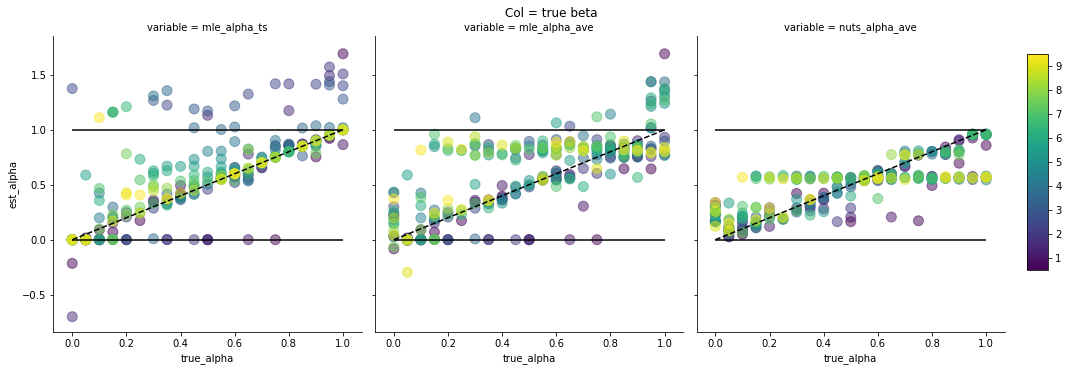

In [10]:
tmp = dfa[(dfa['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()
g = sns.FacetGrid(tmp, col = "variable", height =5)

vmin, vmax = np.min(tmp.true_beta), np.max(tmp.true_beta)

g = g.map(facet_scatter, 'true_alpha', 'value', "true_beta",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

g.map(const_line)

g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)

# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_alpha", "est_alpha")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = true beta")

If we color the $\alpha$ estimates by the raw deviance of $\beta$ instead of true $\beta$ used in data generation (that we would not know in an empirical setting) we find that <font color='red'>**for the range of $\beta$s that we care for the NUTS estimates diverge less from the true values.**

Text(0.5, 0.98, 'Col = beta dev')

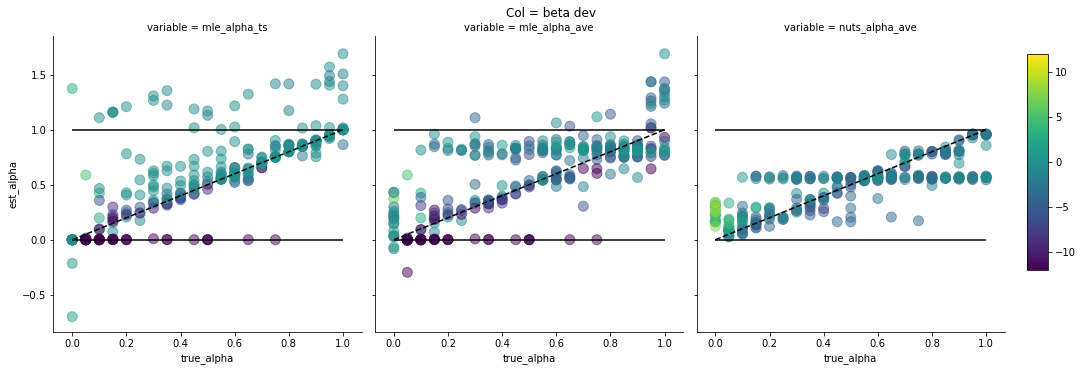

In [11]:
ttmp = dfa[(dfa['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()

g = sns.FacetGrid(tmp, col = "variable", height =5)

#vmin, vmax = np.min(tmp.beta_dev), np.max(tmp.beta_dev)
vmin, vmax = -12, 12

g = g.map(facet_scatter, 'true_alpha', 'value', "beta_dev",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

g.map(const_line)

g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)
# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_alpha", "est_alpha")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = beta dev")

Looking at the raw deviations of $\alpha$ estimates for the three methods we find that the MLE estimates using the true starting values peak most strongly around 0 suggesting better fits.  
However, MLE the true starting value seems like an unfair advantage for this method compared to the others because we would not know the true parameter values for subjects' data in empirical settings.  
NUTS estimates have the second largest peak around 0 and also less extreme deviations overall.

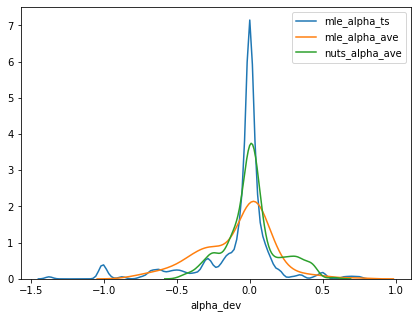

In [12]:
plt.rcParams["figure.figsize"][0] = 7
plt.rcParams["figure.figsize"][1] = 5

tmp = dfa[(dfa['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()

for i in tmp.variable.unique():
    sns.distplot(tmp[(tmp['variable']==i)].alpha_dev, hist = False, label = i)

#### $\beta$ estimates

In [13]:
def const_line(*args, **kwargs):
    x = np.linspace(0, 10, 100)
    plt.plot(x, x, "--",C='k')
    
def h_lines(*args, **kwargs):
    x = np.linspace(0, 10, 100)
    plt.hlines(10, 0, 10)

- MLE with true starts has both the best and the worst $\beta$ estimates (in the range of true $\beta$s we are interested in, i.e. 0<$\beta$<10). For large $\alpha$s $\beta$s are estimated perfectly. For small ones (not all shown below) there are some wildly diverging results
- MLE with random starts has the same problem for small $\alpha$s and worse yet for large $\alpha$s $\beta$s hover around a small range of large and divergent values.
- NUTs estimates are not very good overall either but at least they are not widely out of bounds for any case, including and especially small $\alpha$s and at least for a range of 0<$\beta$<4 it does a better job than MLE with random starts.

Text(0.5, 0.98, 'Col = true alpha')

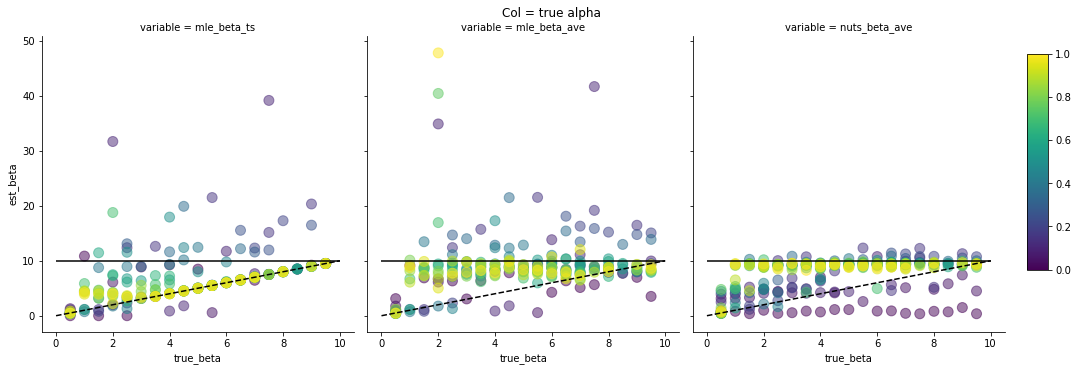

In [14]:
tmp = dfb[(dfb['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()
tmp = tmp[(abs(tmp['value'])<50)].copy()
g = sns.FacetGrid(tmp, col = "variable", height =5)

vmin, vmax = np.min(tmp.true_alpha), np.max(tmp.true_alpha)

g = g.map(facet_scatter, 'true_beta', 'value', "true_alpha",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

g.map(const_line)
g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)

# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_beta", "est_beta")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = true alpha")

When coloring the $\beta$ estimates by divergence of $\alpha$ estimates instead of the true $\alpha$ values we find that in the true $\beta$ range we are interested in $\alpha$ estimates are similarly divergent from their true values.

Text(0.5, 0.98, 'Col = alpha dev')

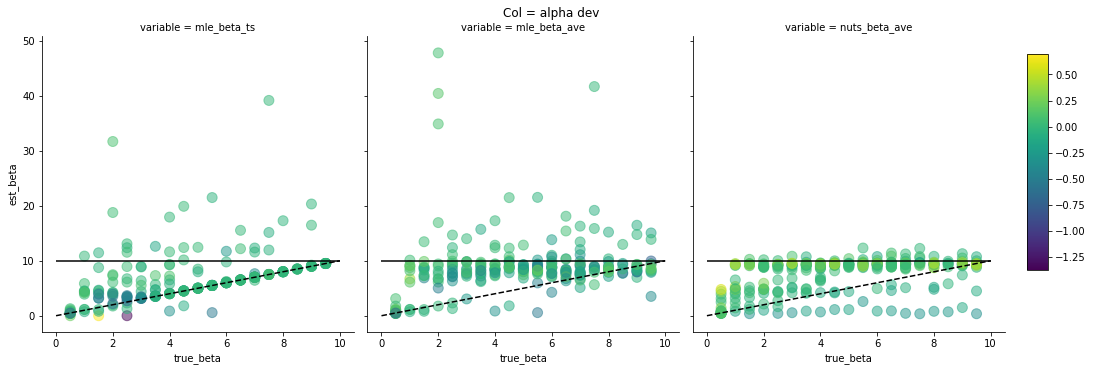

In [15]:
tmp = dfb[(dfb['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()
tmp = tmp[(abs(tmp['value'])<50)].copy()
g = sns.FacetGrid(tmp, col = "variable", height =5)

vmin, vmax = np.min(tmp.alpha_dev), np.max(tmp.alpha_dev)

g = g.map(facet_scatter, 'true_beta', 'value', "alpha_dev",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

g.map(const_line)
g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)

# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_beta", "est_beta")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = alpha dev")

When looking at the distribution of the divergences of the $\beta$ estimates we find that although the MLE estimator with true starts appeared to have the most values on the unit line its wildly off estimates for small true $\alpha$s gives the distributions a very long tail. <font color=red>In the range of acceptable divergences the NUTS estimator outperforms both MLE estimators.

(-20, 10)

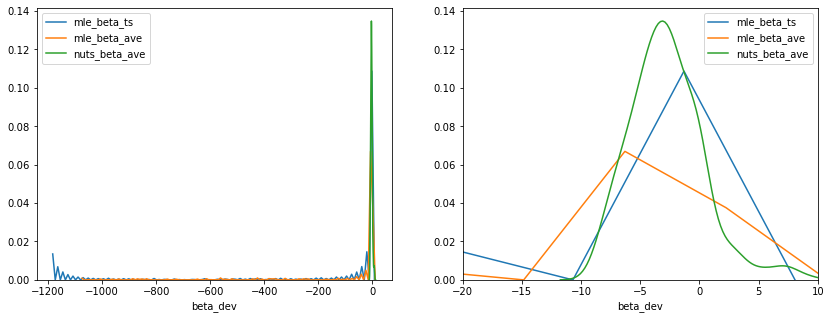

In [16]:
plt.rcParams["figure.figsize"][0] = 14
plt.rcParams["figure.figsize"][1] = 5

tmp = dfb[(dfb['true_beta']>0)].copy()
tmp = tmp[(tmp['true_beta']<10)].copy()

fig, (ax1, ax2) = plt.subplots(1,2)

for i in tmp.variable.unique():
    sns.distplot(tmp[(tmp['variable']==i)].beta_dev, ax = ax1, hist = False, label = i)

for i in tmp.variable.unique():
    sns.distplot(tmp[(tmp['variable']==i)].beta_dev, ax = ax2, hist = False, label = i)
    
ax2.set_xlim(-20, 10)


Text(0.5, 0.98, 'Col = true alpha')

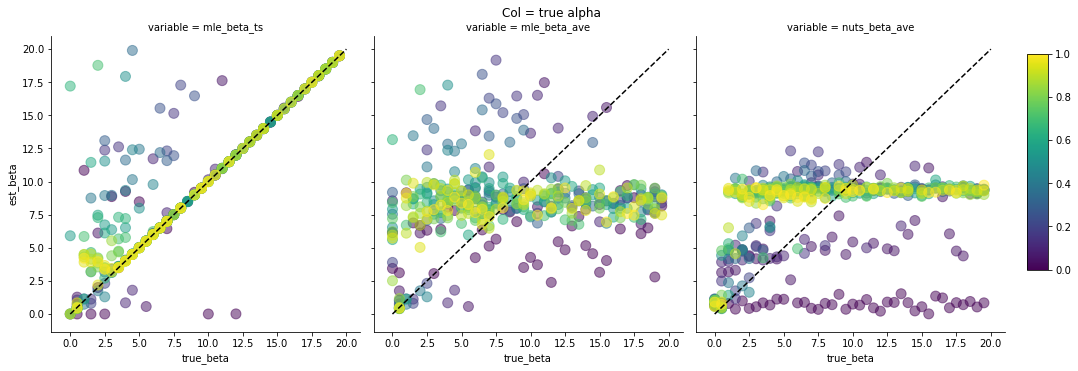

In [17]:
tmp = dfb[(dfb['value']>=0)].copy()
tmp = tmp[(tmp['value']<20)]

g = sns.FacetGrid(tmp, col = "variable", height =5)

vmin, vmax = np.min(tmp.true_alpha), np.max(tmp.true_alpha)

g = g.map(facet_scatter, 'true_beta', 'value', "true_alpha",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

def const_line(*args, **kwargs):
    x = np.linspace(0, 20, 200)
    plt.plot(x, x, "--",C='k')

g.map(const_line)

#g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)
# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_beta", "est_beta")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = true alpha")

Text(0.5, 0.98, 'Col = alpha dev')

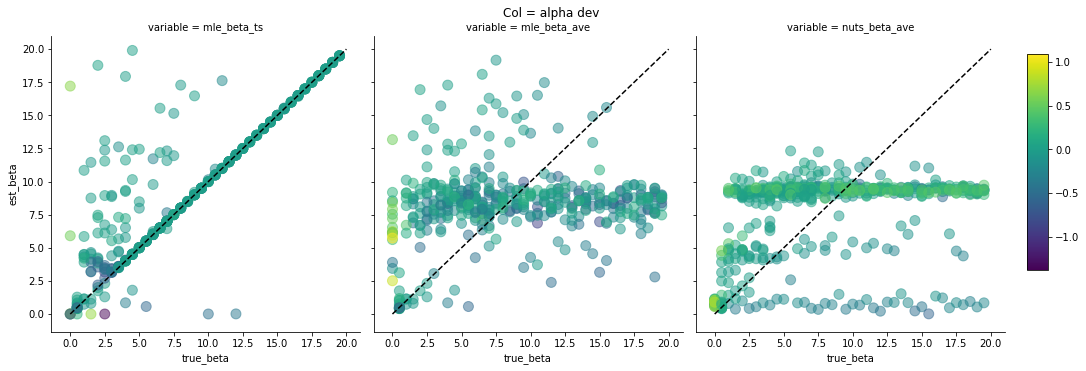

In [18]:
tmp = dfb[(dfb['value']>=0)].copy()
tmp = tmp[(tmp['value']<20)]

g = sns.FacetGrid(tmp, col = "variable", height =5)

vmin, vmax = np.min(tmp.alpha_dev), np.max(tmp.alpha_dev)

g = g.map(facet_scatter, 'true_beta', 'value', "alpha_dev",
          s=100, alpha=0.5, vmin=vmin, vmax=vmax)

def const_line(*args, **kwargs):
    x = np.linspace(0, 20, 200)
    plt.plot(x, x, "--",C='k')

g.map(const_line)

#g.map(h_lines)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax)
# Draw the colorbar
g.fig.colorbar(points, cax=cax)

g.set_axis_labels("true_beta", "est_beta")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Col = alpha dev")

(-15, 15)

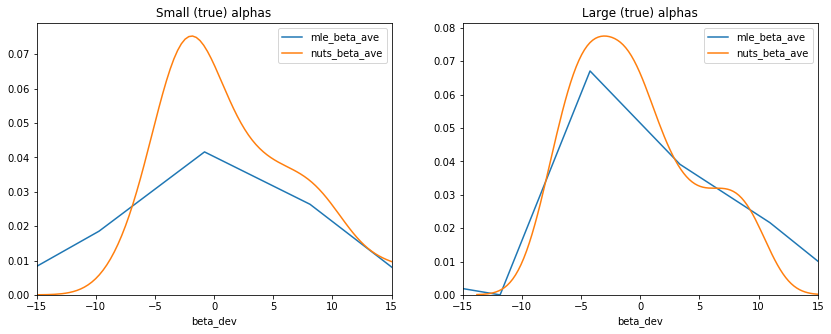

In [19]:
plt.rcParams["figure.figsize"][0] = 14
plt.rcParams["figure.figsize"][1] = 5

fig, (ax1, ax2) = plt.subplots(1, 2)

df1 = dfb[(dfb['true_alpha']<=.5)].copy()
df2 = dfb[(dfb['true_alpha']>.5)].copy()

#for i in df1.variable.unique():
# mle_alpha_ts is not realistic because we don't know the true parameter values for subjects' data
# Evaluating mle compared to nuts using the true starting value seems like a an unfair advantage
for i in ["mle_beta_ave", "nuts_beta_ave"]:
    sns.distplot(df1[(df1['variable']==i)].beta_dev, ax=ax1, hist = False, label = i)
    sns.distplot(df2[(df2['variable']==i)].beta_dev, ax=ax2, hist = False, label = i)

ax1.set_title("Small (true) alphas")
ax2.set_title("Large (true) alphas")
ax1.set_xlim(-15, 15)
ax2.set_xlim(-15, 15)